# Информационная безопасность интеллектуальных систем

Верхотуров В.С. БСМО-31-24

## Подготовка данных

Загружаются данные из CSV файла с помощью библиотеки pandas и выводятся первые несколько строк для ознакомления с ними.

In [39]:
import pandas as pd

In [40]:
df = pd.read_csv("seattleWeather_1948-2017.csv")
df.head()

,DATE,PRCP,TMAX,TMIN,RAIN
0,1948-01-01,0.47,51,42,True
1,1948-01-02,0.59,45,36,True
2,1948-01-03,0.42,45,35,True
3,1948-01-04,0.31,45,34,True
4,1948-01-05,0.17,45,32,True


Извлекаются уникальные значения из столбца 'RAIN', чтобы понять, какие значения там присутствуют.

In [41]:
df['RAIN'].unique()

array([True, False, nan], dtype=object)

Печатаются строки, в которых столбец 'RAIN' имеет пропущенные значения (NaN).

In [42]:
df[df['RAIN'].isnull()]

,DATE,PRCP,TMAX,TMIN,RAIN
18415,1998-06-02,NaN,72,52,NaN
18416,1998-06-03,NaN,66,51,NaN
21067,2005-09-05,NaN,70,52,NaN


Удаляются все строки с пропущенными значениями и идет проверка, сколько строк осталось в датафрейме.

In [43]:
df = df.dropna()
df.shape

(25548, 5)

Идет преобразование столбец 'RAIN' в целочисленный тип данных, так как в этом столбце скорее всего содержатся 0 и 1 (признак наличия дождя).
Выводится количество уникальных значений для этого столбца.

In [44]:
df['RAIN'] = df['RAIN'].astype('int')
df['RAIN'].value_counts()

RAIN
0    14648
1    10900
Name: count, dtype: int64

Удаление столбца 'DATE' и 'PRCP', так как он не будет использоваться в анализе.

In [45]:
df = df.drop('DATE',axis=1)
df = df.drop('PRCP',axis=1)

## Обучение

Рзаделение данные на признаки (X) и целевую переменную (y), где y — это столбец 'RAIN' (моделируемое значение), а X — остальные столбцы.

In [46]:
from sklearn.model_selection import train_test_split

y = df.pop('RAIN')
X = df

X_train, X_test, y_train, y_test = (
    train_test_split(X, y, train_size=.75, random_state=8)
)

Создание модели логистической регрессии с методом оптимизации 'lbfgs' и обучаем её на обучающих данных.

In [47]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(solver='lbfgs')
lr_model.fit(X_train, y_train)

LogisticRegression()

## AUC

Использована обученная модель для прогнозирования вероятности принадлежности классу "дождь" (метка "1") для тестовых данных.

In [48]:
from sklearn.metrics import roc_curve, roc_auc_score

lr_probs = lr_model.predict_proba(X_test)
lr_probs = lr_probs[:, 1]


lr_auc = roc_auc_score(y_test, lr_probs)
print('LogisticRegression: AUROC = %.3f' % (lr_auc))
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

LogisticRegression: AUROC = 0.830


Построена кривая ROC для модели логистической регрессии. Эта кривая показывает зависимость между долей ложных срабатываний (False Positive Rate, FPR) и долей истинных срабатываний (True Positive Rate, TPR).

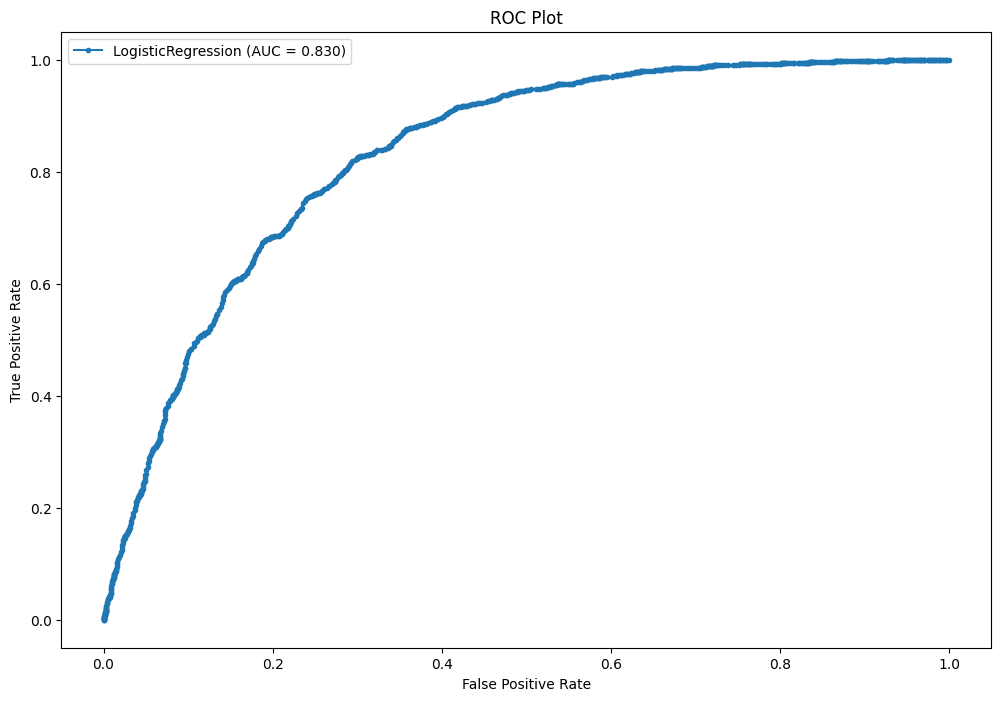

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(lr_fpr, lr_tpr, 
         marker='.', 
         label='LogisticRegression (AUC = %0.3f)' % lr_auc)


plt.title('ROC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()  
plt.show()

## Noise

Добавляется шум в целевую переменную, случайным образом меняя значения (инвертируются 10% меток) в столбце 'RAIN'. Это моделирует ситуацию с нарушением целостности данных. Прогнозируются вероятности для модели с шумными данными и рассчитываем AUC для этой модели. Строятся две кривые ROC: для исходной модели и модели с шумными данными, сравнивая их AUC.

LogisticRegression with Noise: AUROC = 0.765


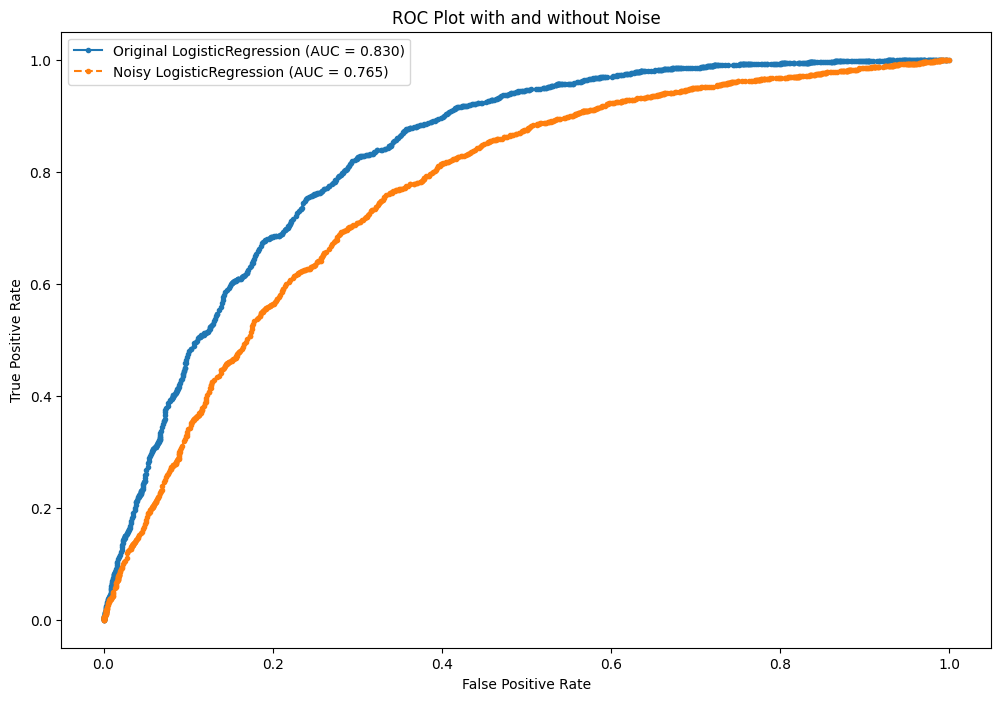

In [50]:
import numpy as np

# Noise, flipping 10%
flip_indices = np.random.choice(y.index, 
                                size=int(0.1 * len(y)), 
                                replace=False)
y_noisy = y.copy()
y_noisy.loc[flip_indices] = 1 - y_noisy.loc[flip_indices]

X_train, X_test, y_train_noisy, y_test_noisy = (
    train_test_split(
    X, y_noisy, train_size=0.75, random_state=8
))

lr_model_noisy = LogisticRegression(solver='lbfgs')
lr_model_noisy.fit(X_train, y_train_noisy)

lr_probs_noisy = lr_model_noisy.predict_proba(X_test)[:, 1]
lr_auc_noisy = roc_auc_score(y_test_noisy, lr_probs_noisy)

print('LogisticRegression with Noise: AUROC = %.3f' % (lr_auc_noisy))

lr_fpr_noisy, lr_tpr_noisy, _ = roc_curve(y_test_noisy, lr_probs_noisy)

plt.figure(figsize=(12, 8))
plt.plot(lr_fpr, lr_tpr, 
         marker='.', 
         label='Original LogisticRegression (AUC = %0.3f)' % lr_auc)
plt.plot(lr_fpr_noisy, lr_tpr_noisy, 
         marker='.', 
         linestyle='--', 
         label='Noisy LogisticRegression (AUC = %0.3f)' % lr_auc_noisy)

plt.title('ROC Plot with and without Noise')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()  
plt.show()


## Триггер

Добавлен триггер на создание записи с аномальной температкурой (выше +40 С или ниже -30 С).
```sql
-- Install pg_http
-- CREATE EXTENSION IF NOT EXISTS http;

CREATE OR REPLACE FUNCTION send_telegram_notification(tmax_value float)
RETURNS void LANGUAGE plpgsql AS $$
DECLARE
    telegram_url text;
    message text;
BEGIN
    -- Telegram API URL
    telegram_url := 'https://api.telegram.org/bot<YOUR_BOT_TOKEN>/sendMessage';
    
    -- Formatting message
    message := 'Alert! tmax value is ' || tmax_value 
                    || '. It is out of the acceptable range.';

    -- Send HTTP request
    PERFORM http_post(
        telegram_url,
        'chat_id=<YOUR_CHAT_ID>&text=' || message,
        'Content-Type=application/x-www-form-urlencoded'
    );
END;
$$;
```

```sql
CREATE OR REPLACE FUNCTION check_tmax_and_notify()
RETURNS TRIGGER AS $$
BEGIN
    -- Check tmax and tmin
    IF NEW.tmax > 104 OR NEW.tmax < -22 OR NEW.tmin > 104 OR NEW.tmin < -22 THEN
        -- Send message in Telegram
        PERFORM send_telegram_notification(NEW.tmax);
    END IF;
    RETURN NEW;
END;
$$ LANGUAGE plpgsql;

```

## Вывод

Весь процесс включает в себя загрузку данных, предобработку, обучение модели логистической регрессии, проверку её качества с использованием кривой ROC и нарушение целостности данных с помощью добавление шума для анализа устойчивости модели. Визуализация ROC кривой помогает сравнить качество модели с добавленным шумом и без него.